In [1]:
"""Demonstrate how probabilistic solvers work via conditioning on constraints."""

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend

from probdiffeq import ivpsolve, ivpsolvers, stats, taylor

In [2]:
if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

In [3]:
# Create an ODE problem


@jax.jit
def vector_field(y, t):  # noqa: ARG001
    """Evaluate the logistic ODE vector field."""
    return 10.0 * y * (2.0 - y)


t0, t1 = 0.0, 0.5
u0 = jnp.asarray([0.1])

In [4]:
# Assemble the discretised prior (with and without the correct Taylor coefficients)

NUM_DERIVATIVES = 2
tcoeffs_like = [u0] * (NUM_DERIVATIVES + 1)
ts = jnp.linspace(t0, t1, num=500, endpoint=True)
init_raw, transitions, ssm = ivpsolvers.prior_wiener_integrated_discrete(
    ts, tcoeffs_like, output_scale=100.0, ssm_fact="dense"
)

markov_seq_prior = stats.MarkovSeq(init_raw, transitions)


tcoeffs = taylor.odejet_padded_scan(
    lambda y: vector_field(y, t=t0), (u0,), num=NUM_DERIVATIVES
)
init_tcoeffs = ssm.normal.from_tcoeffs(tcoeffs)
markov_seq_tcoeffs = stats.MarkovSeq(init_tcoeffs, transitions)

In [5]:
# Compute the posterior

init, ibm, ssm = ivpsolvers.prior_wiener_integrated(
    tcoeffs, output_scale=1.0, ssm_fact="dense"
)
ts1 = ivpsolvers.correction_ts1(vector_field, ssm=ssm)
strategy = ivpsolvers.strategy_fixedpoint(ssm=ssm)
solver = ivpsolvers.solver(strategy, prior=ibm, correction=ts1, ssm=ssm)
adaptive_solver = ivpsolvers.adaptive(solver, atol=1e-1, rtol=1e-2, ssm=ssm)

dt0 = ivpsolve.dt0(lambda y: vector_field(y, t=t0), (u0,))
sol = ivpsolve.solve_adaptive_save_at(
    init, save_at=ts, dt0=1.0, adaptive_solver=adaptive_solver, ssm=ssm
)
markov_seq_posterior = stats.markov_select_terminal(sol.posterior)

In [ ]:
# Compute marginals
margs_prior = stats.markov_marginals(markov_seq_prior, reverse=False, ssm=ssm)
margs_tcoeffs = stats.markov_marginals(markov_seq_tcoeffs, reverse=False, ssm=ssm)
margs_posterior = stats.markov_marginals(markov_seq_posterior, reverse=True, ssm=ssm)

In [ ]:
# Compute samples

num_samples = 5
key = jax.random.PRNGKey(seed=1)
samples_prior, _ = stats.markov_sample(
    key, markov_seq_prior, shape=(num_samples,), reverse=False, ssm=ssm
)
samples_tcoeffs, _ = stats.markov_sample(
    key, markov_seq_tcoeffs, shape=(num_samples,), reverse=False, ssm=ssm
)
samples_posterior, _ = stats.markov_sample(
    key, markov_seq_posterior, shape=(num_samples,), reverse=True, ssm=ssm
)

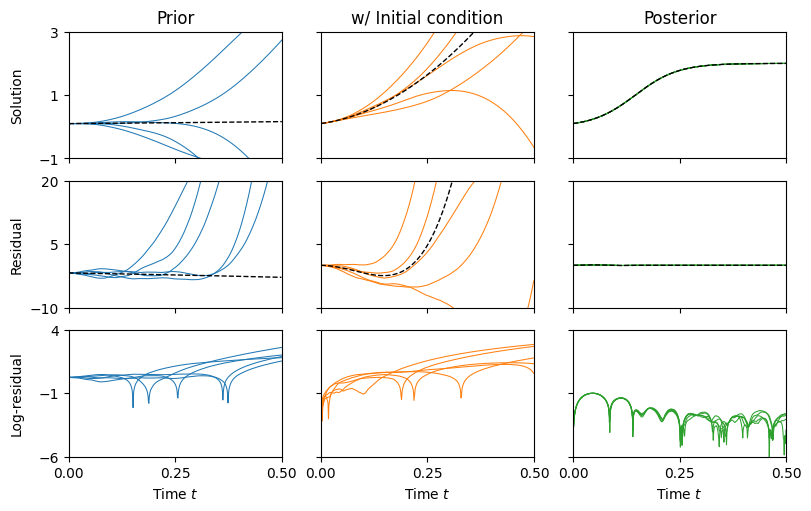

In [8]:
# Plot the results

fig, (axes_state, axes_residual, axes_log_abs) = plt.subplots(
    nrows=3, ncols=3, sharex=True, sharey="row", constrained_layout=True, figsize=(8, 5)
)
axes_state[0].set_title("Prior")
axes_state[1].set_title("w/ Initial condition")
axes_state[2].set_title("Posterior")

sample_style = {"marker": "None", "alpha": 0.99, "linewidth": 0.75}
mean_style = {
    "marker": "None",
    "color": "black",
    "linestyle": "dashed",
    "linewidth": 0.99,
}


def residual(x, t):
    """Evaluate the ODE residual."""
    return x[1] - jax.vmap(jax.vmap(vector_field), in_axes=(0, None))(x[0], t)


residual_prior = residual(samples_prior, ts[:-1])
residual_tcoeffs = residual(samples_tcoeffs, ts[:-1])
residual_posterior = residual(samples_posterior, ts[:-1])


for i in range(num_samples):
    # Plot all state-samples
    axes_state[0].plot(ts[1:], samples_prior[0][i, ..., 0], **sample_style, color="C0")
    axes_state[1].plot(
        ts[1:], samples_tcoeffs[0][i, ..., 0], **sample_style, color="C1"
    )
    axes_state[2].plot(
        ts[:-1], samples_posterior[0][i, ..., 0], **sample_style, color="C2"
    )

    # Plot all residual-samples
    axes_residual[0].plot(ts[:-1], residual_prior[i, ...], **sample_style, color="C0")
    axes_residual[1].plot(ts[:-1], residual_tcoeffs[i, ...], **sample_style, color="C1")
    axes_residual[2].plot(
        ts[:-1], residual_posterior[i, ...], **sample_style, color="C2"
    )

    # Plot all log-residual samples
    axes_log_abs[0].plot(
        ts[:-1], jnp.log10(jnp.abs(residual_prior))[i, ...], **sample_style, color="C0"
    )
    axes_log_abs[1].plot(
        ts[:-1],
        jnp.log10(jnp.abs(residual_tcoeffs))[i, ...],
        **sample_style,
        color="C1",
    )
    axes_log_abs[2].plot(
        ts[:-1],
        jnp.log10(jnp.abs(residual_posterior))[i, ...],
        **sample_style,
        color="C2",
    )
#


def residual_mean(x, t):
    """Evaluate the ODE residual."""
    return x[1] - jax.vmap(vector_field)(x[0], t)


# # Plot state means
axes_state[0].plot(ts[1:], ssm.stats.qoi(margs_prior)[0], **mean_style)
axes_state[1].plot(ts[1:], ssm.stats.qoi(margs_tcoeffs)[0], **mean_style)
axes_state[2].plot(ts[:-1], ssm.stats.qoi(margs_posterior)[0], **mean_style)

# # Plot residual means
axes_residual[0].plot(
    ts[:-1], residual_mean(ssm.stats.qoi(margs_prior), ts[:-1]), **mean_style
)
axes_residual[1].plot(
    ts[:-1], residual_mean(ssm.stats.qoi(margs_tcoeffs), ts[:-1]), **mean_style
)
axes_residual[2].plot(
    ts[:-1], residual_mean(ssm.stats.qoi(margs_posterior), ts[:-1]), **mean_style
)


# Set the x- and y-ticks/limits
axes_state[0].set_xticks((t0, (t0 + t1) / 2, t1))
axes_state[0].set_xlim((t0, t1))

axes_state[0].set_ylim((-1, 3))
axes_state[0].set_yticks((-1, 1, 3))

axes_residual[0].set_ylim((-10.0, 20))
axes_residual[0].set_yticks((-10.0, 5, 20))

axes_log_abs[0].set_ylim((-6, 4))
axes_log_abs[0].set_yticks((-6, -1, 4))

# Label the x- and y-axes
axes_state[0].set_ylabel("Solution")
axes_residual[0].set_ylabel("Residual")
axes_log_abs[0].set_ylabel(r"Log-residual")
axes_log_abs[0].set_xlabel("Time $t$")
axes_log_abs[1].set_xlabel("Time $t$")
axes_log_abs[2].set_xlabel("Time $t$")

# Show the result
fig.align_ylabels()
plt.show()